## 条件付き画像生成プログラム

粗い画像を条件付きの入力画像$x$として、高解像度の画像生成を行うプログラムの確認

$p(x)$に条件$y$を付与した条件付きスコアの学習

$$
\log \nabla_x p_\theta(x|y)=\log \nabla_x p_\theta(x) +\gamma \log \nabla_x p_\theta(y|x)
$$


拡散モデルのノイズ除去のUnetにノイズ画像,timestep,条件画像の引数を入力する。
$$
x_{denoise} = Unet(x_{noise},t,x_{conditional})
$$

In [1]:
!pip install torch torchvision matplotlib tqdm

  Using cached torch-2.7.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached torchvision-0.22.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached matplotlib-3.10.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.6.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.6.80-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.5.1.17-py3-none-manylinux

In [1]:
import math
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm


img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 10
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def resize_images(batch_vectors, original_size=28, new_size=7):
    """
    784次元の1次元ベクトル（28×28画像）を7×7に変換（バッチ対応）
    
    Parameters:
        batch_vectors: torch.Tensor, shape (B, 784)
        original_size: int, 元の1辺の長さ（28）
        new_size: int, 新しい1辺の長さ（7）
    
    Returns:
        torch.Tensor, shape (B, 49) - リサイズされた1次元ベクトル
    """
    B = batch_vectors.size(0)  # バッチサイズ

    # 1次元を28×28画像にreshape (B, 1, 28, 28)
    images = batch_vectors.view(B, 1, original_size, original_size)

    # リサイズ (B, 1, 7, 7)
    resized_images = F.interpolate(images, size=(new_size, new_size), mode='bilinear', align_corners=False)

    # 再度flatten (B, 49)
    flattened_resized = resized_images.view(B, new_size * new_size)

    return flattened_resized

def show_images(images, labels=None, rows=2, cols=10):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax = fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i], cmap='gray')
            if labels is not None:
                ax.set_xlabel(labels[i].item())
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            i += 1
    plt.tight_layout()
    plt.show()

def _pos_encoding(time_idx, output_dim, device='cpu'):
    t, D = time_idx, output_dim
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device)
    div_term = torch.exp(i / D * math.log(10000))

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])
    return v

def pos_encoding(timesteps, output_dim, device='cpu'):
    batch_size = len(timesteps)
    device = timesteps.device
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(timesteps[i], output_dim, device)
    return v

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )

    def forward(self, x, v):
        N, C, _, _ = x.shape
        v = self.mlp(v)
        v = v.view(N, C, 1, 1)
        y = self.convs(x + v)
        return y

class UNetCond(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=100, num_labels=None):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

        if num_labels is not None:
            #self.label_emb = nn.Embedding(num_labels, time_embed_dim)
            self.label_emb =nn.Linear(7*7, time_embed_dim)

    def forward(self, x, timesteps, labels=None):
        t = pos_encoding(timesteps, self.time_embed_dim)

        if labels is not None:
            t += self.label_emb(labels)

        x1 = self.down1(x, t)
        x = self.maxpool(x1)
        x2 = self.down2(x, t)
        x = self.maxpool(x2)

        x = self.bot1(x, t)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, t)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, t)
        x = self.out(x)
        return x


class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alpha_bars[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx]  # (N,)
        alpha_bar = alpha_bar.view(alpha_bar.size(0), 1, 1, 1)  # (N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self, model, x, t, labels):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alphas[0] is for t=1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x, t, labels)  # add lable embedding
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # no noise at t=1

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar))
        return mu + noise * std

    def reverse_to_img(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)

    def sample(self, model, x_shape=(20, 1, 28, 28), labels=None):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)
        #if labels is None:
            #labels = torch.randint(0, 10, (len(x),), device=self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t, labels)

        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
        return images#, labels

100%|██████████| 469/469 [00:19<00:00, 23.51it/s]


Epoch 0 | Loss: 0.04932990335404619


100%|██████████| 469/469 [00:15<00:00, 29.69it/s]


Epoch 1 | Loss: 0.028545167158121495


100%|██████████| 469/469 [00:15<00:00, 29.49it/s]


Epoch 2 | Loss: 0.02369801381797488


100%|██████████| 469/469 [00:15<00:00, 29.61it/s]


Epoch 3 | Loss: 0.02114135245365629


100%|██████████| 469/469 [00:15<00:00, 30.90it/s]


Epoch 4 | Loss: 0.01988051813850398


100%|██████████| 469/469 [00:15<00:00, 29.61it/s]


Epoch 5 | Loss: 0.018593304234542953


100%|██████████| 469/469 [00:15<00:00, 29.55it/s]


Epoch 6 | Loss: 0.01804272406526021


100%|██████████| 469/469 [00:15<00:00, 29.52it/s]


Epoch 7 | Loss: 0.016698085603667603


100%|██████████| 469/469 [00:15<00:00, 30.90it/s]


Epoch 8 | Loss: 0.016609823982566913


100%|██████████| 469/469 [00:15<00:00, 29.62it/s]


Epoch 9 | Loss: 0.01603042817057005


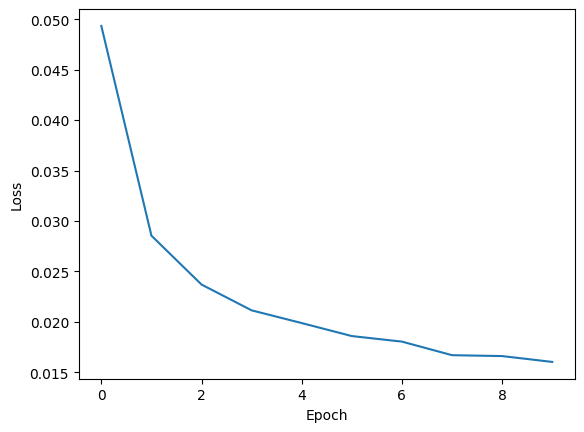

In [2]:
preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='./data', download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

diffuser = Diffuser(num_timesteps, device=device)
model = UNetCond(num_labels=10)
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)

losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    # generate samples every epoch ===================
    # images, labels = diffuser.sample(model)
    # show_images(images, labels)
    # ================================================

    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        labels = labels.to(device)
        t = torch.randint(1, num_timesteps+1, (len(x),), device=device)
        label_x = resize_images(x) # 7×7の低解像度化
        x_noisy, noise = diffuser.add_noise(x, t )
        noise_pred = model(x_noisy, t, label_x)
        loss = F.mse_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch {epoch} | Loss: {loss_avg}')

# plot losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


条件付きの画像生成  
低解像度の条件付き画像を入力として、画像を生成

100%|██████████| 1000/1000 [00:04<00:00, 220.54it/s]


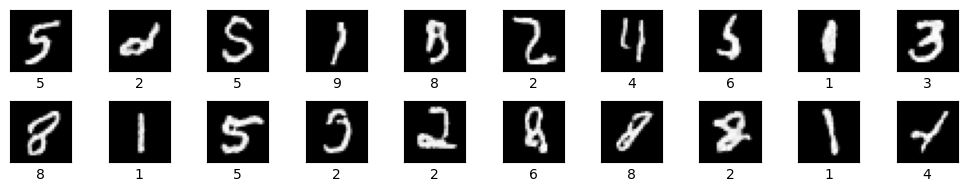

In [3]:
preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='./data', download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=20, shuffle=True)

x_shape=(20, 1, 28, 28)

for images, labels in dataloader:
    x = images.to(device)
    label_x = resize_images(x)
    images = diffuser.sample(model,x_shape,label_x)
    show_images(images, labels)
    break;